# Chapter 2: Neural Network Classification
What is a classification problem?
<br> Examples:
<br> Spam mail: binary classification, spam or not spam
<br> Is this a photo of x,y or z?: Multiclass classification
<br> What tags should this article have?: Multilabel classification
<br><br> Classification is a problem of predicting whether something is one thing or another (there can be multiple things as options)

In [176]:
import sklearn

In [177]:
from sklearn.datasets import make_circles

# Make 1000 samples
N_samples = 1000

# Create circles
X, y = make_circles(n_samples=N_samples,
                    noise=.05,
                    random_state=42)

## 1. Make classification data and get it ready

In [178]:
len(X), len(y)

(1000, 1000)

In [179]:
print(f"First 5 samples of X: {X[:5]}\n")
print(f"First 5 samples of y: \n{y[:5]}")

First 5 samples of X: [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]

First 5 samples of y: 
[1 1 1 1 0]


In [180]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


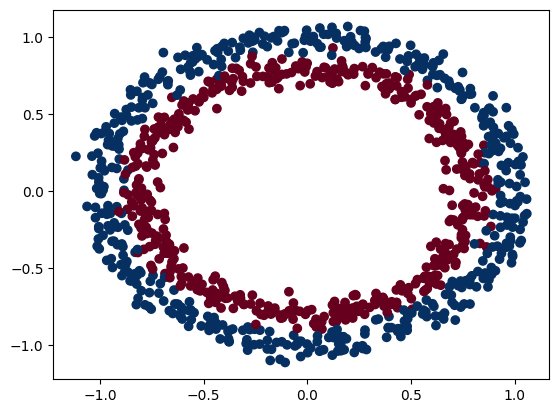

In [181]:
# Visualize data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdBu_r)

**Note**: The data we're working with is often referred to as a toy data set, a dataset that is small enough to expirement but still sizeable enough to practice the fundementals on.

### 1.1 Check input and output shapes

In [182]:
X.shape, y.shape


((1000, 2), (1000,))

In [183]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for  onw sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.74220688 0.24668576] and the same for y: 1
Shapes for  onw sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create test splits

In [184]:
import torch
torch.__version__

'2.7.1'

In [185]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [186]:
type(X), type(y), X.dtype, y.dtype


(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [187]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [188]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model
Let's build a model to classify our blue and red dots.
<br><br> To do so, we want to:
<br> 1. Setup device agnostic code
<br> 2. Construct a model (by subclassing 'nn.module')
<br> 3. Define a loss funciton and optimizer
<br> 4. Create a training and test loop


In [189]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

Model plan:
<br> 1. Subclass 'nn.module'
<br> 2. Creates 2 'nn.linear()' layers that are capable of handling the shapes of our data
<br> 3. Defines 'forward()' method that outlines the forward pass (or forward computation) of the model
<br> 4. Instantiates an instance of our model class and send it to the target device

In [190]:
# 1. Constructs a model that subclasses nn.module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features | Note: more hidden layers = more opportunities for models to learn patterns
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [191]:
# Replacing previous feature above using nn.sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [192]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [193]:
# Make Predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test sample: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 samples of predictions:\n {torch.round(untrained_preds[:5])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test sample: 200, shape: torch.Size([200, 2])

First 10 samples of predictions:
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss Function and optimizer
<br>
Which should we use?
<br>
For regression we used MAE or couldve even used MSE
<br>
For classification one might want binary corss entropy or categorical cross entropy (cross entropy)
<br>
As a reminder, the loss function measures how wrong your models predictions are
<br>
And for optimizers, two of the most common and useful are SGD and adam, however PyTorch has many more built in
<br><br><br>
What is binary cross entropy / log loss?
<br> Binary cross-entropy (log loss) is a loss function used in binary classification problems. It quantifies the difference between the actual class labels (0 or 1) and the predicted probabilities output by the model. The lower the binary cross-entropy value, the better the model’s predictions align with the true labels.

In [194]:
# Setup the loss function
# BCELoss = Requires inout layers to have gone though the sigmoid activation function prior to the input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [195]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [196]:
# Calculate accuracy - out of 100 examples, what percent does the model get it right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = correct / len(y_true) * 100
    return accuracy

## 3. Train Model
To train our model, we're going to need to build a training loop:
1. Forward poss
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backprop)
5. Optimizer step (gradient decent)
6. Find out whats happening
7.

## 3.1 from raw logits -> prediction probabilities -> prediction labels
Our model outputs are going to be raw **logits**.
<br> We can convert these **logits** into prediction probabilities by passes them to some kind of activation function (e.g. sigmoid for crossentropy and software for multiclass classification).
<br>Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the 'argmax()'
<br><br><br>
What are logits (in neural networks)?
<br>In neural networks, particularly for classification tasks, logits are the raw output of the final layer before applying an activation function like softmax to convert them into probabilities. 

In [197]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.no_grad():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0307],
        [-0.0213],
        [ 0.0896],
        [-0.0678],
        [ 0.3020]])

In [198]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4923],
        [0.4947],
        [0.5224],
        [0.4831],
        [0.5749]])

For the predcition probability values, we need to perform a rnage-style rounding on them:
<br> 'y_preds_probs' >= 'y=1' (class 1)
<br> 'y_preds_probs' < 'y=0' (class 0)

In [199]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.equal(y_pred_labels.squeeze(), y_pred_probs.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

False


tensor([0., 0., 1., 0., 1.])

## 3.2 Building a training and test loop

In [200]:
len(y_preds), len(y_train), len(X_test), len(X_train)

(5, 800, 200, 800)

In [201]:
torch.manual_seed(42)
EPOCHS = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred prob -> pred labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()


    ### Testing:
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)

        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)


    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%")


Epoch: 0 | Loss: 0.69802 | Accuracy: 52.25% | Test Loss: 0.69432 | Test Accuracy: 58.00%
Epoch: 10 | Loss: 0.69593 | Accuracy: 51.25% | Test Loss: 0.69299 | Test Accuracy: 54.50%
Epoch: 20 | Loss: 0.69492 | Accuracy: 51.38% | Test Loss: 0.69249 | Test Accuracy: 50.50%
Epoch: 30 | Loss: 0.69436 | Accuracy: 51.25% | Test Loss: 0.69232 | Test Accuracy: 49.50%
Epoch: 40 | Loss: 0.69401 | Accuracy: 51.00% | Test Loss: 0.69229 | Test Accuracy: 51.00%
Epoch: 50 | Loss: 0.69378 | Accuracy: 50.38% | Test Loss: 0.69231 | Test Accuracy: 50.00%
Epoch: 60 | Loss: 0.69362 | Accuracy: 50.12% | Test Loss: 0.69237 | Test Accuracy: 51.50%
Epoch: 70 | Loss: 0.69351 | Accuracy: 50.12% | Test Loss: 0.69245 | Test Accuracy: 51.00%
Epoch: 80 | Loss: 0.69342 | Accuracy: 50.00% | Test Loss: 0.69253 | Test Accuracy: 52.00%
Epoch: 90 | Loss: 0.69335 | Accuracy: 49.50% | Test Loss: 0.69262 | Test Accuracy: 53.00%


## 4. Make predictions and evaluate the model
<br> From the metrics it looks like out model isnt learning anything so to inspect it lets make a visual.
<br> To do so, we're going to import a function call 'plot_decisions_boundary'


In [202]:
import requests
from pathlib import Path

# Download help functions from PyTorch Repo
if Path("helper_functions.py").is_file():
    print("Helper functions imported")
else:
    print("Helper functions not imported")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Helper functions imported


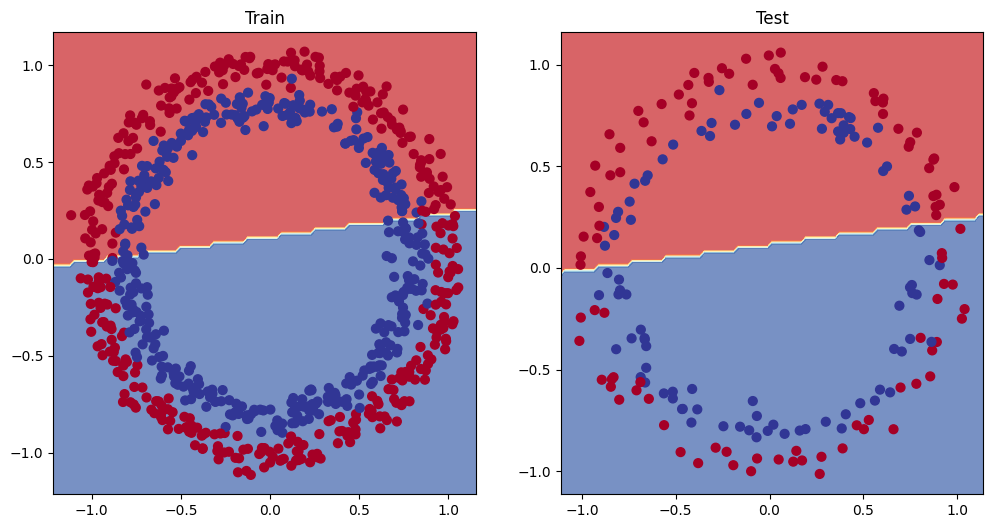

In [203]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (from model perspective)

* Add more layers - give it more chanches to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function
* These are all hyper parameters
<br> Lets try and improve our model by:
* Adding more hidden units 5 -> 10
* Increase number of layers: 2 -> 3
* Increase number of epochs: 100 -> 1000

In [204]:
class circleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # <- more hidden units (5 -> 10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations is faster behind the scenes

model_1 = circleModelV1().to(device)
model_1



circleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [205]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function built-in

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)


In [206]:
# Write a training and evaluation loop
torch.manual_seed(42)
EPOCHS = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred prob -> pred labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. Optimize zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()


    ### Testing:
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)

        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)


    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%")


Epoch: 0 | Loss: 0.69393 | Accuracy: 51.00% | Test Loss: 0.69264 | Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.69367 | Accuracy: 50.38% | Test Loss: 0.69272 | Test Accuracy: 50.50%
Epoch: 20 | Loss: 0.69350 | Accuracy: 50.88% | Test Loss: 0.69285 | Test Accuracy: 50.00%
Epoch: 30 | Loss: 0.69338 | Accuracy: 50.50% | Test Loss: 0.69298 | Test Accuracy: 49.00%
Epoch: 40 | Loss: 0.69329 | Accuracy: 50.38% | Test Loss: 0.69312 | Test Accuracy: 48.50%
Epoch: 50 | Loss: 0.69322 | Accuracy: 50.00% | Test Loss: 0.69325 | Test Accuracy: 51.00%
Epoch: 60 | Loss: 0.69316 | Accuracy: 49.38% | Test Loss: 0.69337 | Test Accuracy: 52.50%
Epoch: 70 | Loss: 0.69312 | Accuracy: 49.12% | Test Loss: 0.69349 | Test Accuracy: 51.00%
Epoch: 80 | Loss: 0.69309 | Accuracy: 50.00% | Test Loss: 0.69360 | Test Accuracy: 52.00%
Epoch: 90 | Loss: 0.69307 | Accuracy: 50.50% | Test Loss: 0.69370 | Test Accuracy: 48.50%
Epoch: 100 | Loss: 0.69305 | Accuracy: 50.50% | Test Loss: 0.69379 | Test Accuracy: 48.00%
Epoch: 110

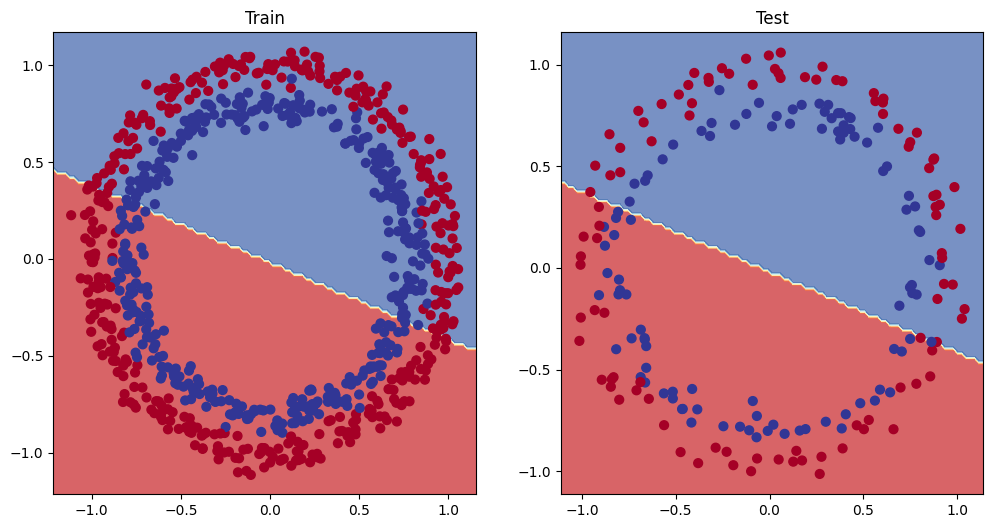

In [207]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


The line just is more zigzag now

### 5.1 Preparing data to see if our model can fit a straight line

In [208]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check Data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [209]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(X_test_regression)


(80, 80, 20, 20)

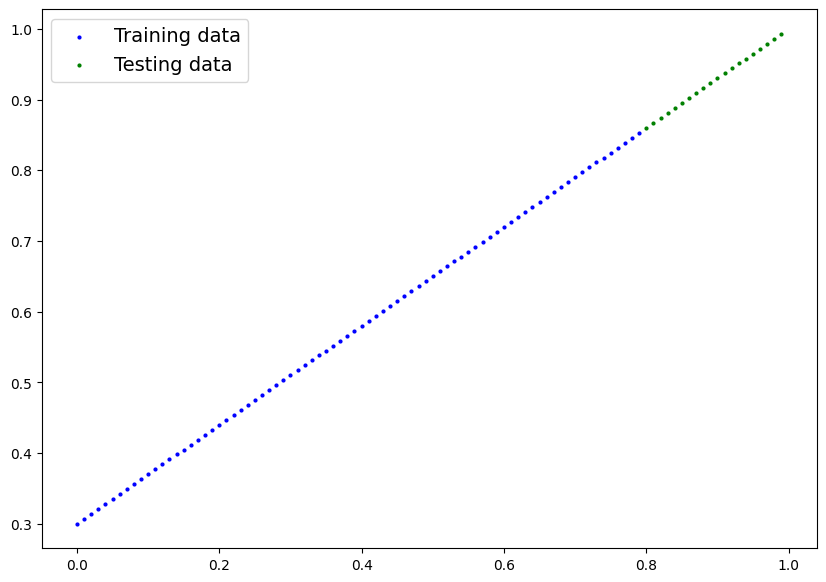

In [210]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,)

### 5.2 Adjusting 'model_1' to fit straight line

In [211]:
# Same architecture as model_1 (but using nn.Sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [212]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)


In [213]:
# Train the model
torch.manual_seed(42)
# Set epochs
EPOCHS = 1000
# Put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training loop
for epoch in range(EPOCHS):
    # 1. Forward Pass
    y_pred = model_2(X_train_regression)
    # 2. Loss func
    loss = loss_fn(y_pred, y_train_regression)
    # 3. Optimize zero grad
    optimizer.zero_grad()
    # 4. Backprop
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")




Epoch: 0 | Loss: 0.75986 | Test Loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test Loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test Loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test Loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test Loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test Loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test Loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test Loss: 0.02127
Epoch: 800 | Loss: 0.05599 | Test Loss: 0.01426
Epoch: 900 | Loss: 0.05571 | Test Loss: 0.00603


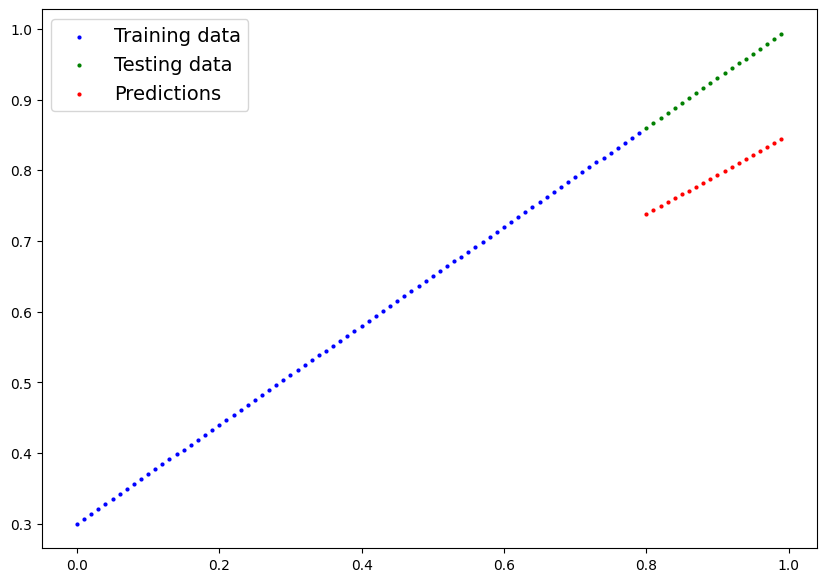

In [214]:
# Turn on evaluation mode
model_2.eval()
# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression).to(device)

# Plot predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())



## 6. The missing piece: non linearity
" What patterns could you find if you were given an infinite aount of straight and non-straight lines?"
<br> or in ml, an infinite of linear and linear functions

### 6.1 Recreating non-linear data (red and blue circles)

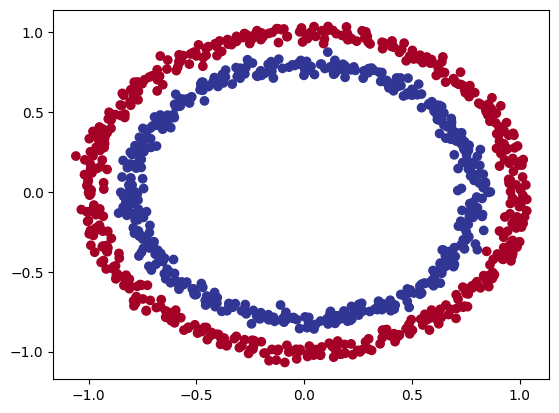

In [215]:
# Make non-linear data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples,noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [216]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non linearity
* Artificial neural networks are a large combination of linear (straight) and non-stright (non-linear) functions which are potentially able to find patterns


In [217]:
# Build a model with
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=20)
        self.layer2 = nn.Linear(in_features=20, out_features=20) # Changed neurons from 10 -> 20 for each layer that says 20
        self.layer3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation functions

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [218]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)


### 6.3 Training a model with non-linearity

In [219]:

# Set random seed
torch.manual_seed(42)
# Set Epochs
EPOCHS = 1000

# Training and test loop
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop
for epoch in range(EPOCHS):

    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> predictions

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backprop
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy}")

Epoch: 0 | Loss: 0.6945 | Accuracy: 47.62% | Test Loss: 0.6920 | Test Accuracy: 54.0
Epoch: 100 | Loss: 0.6910 | Accuracy: 53.12% | Test Loss: 0.6896 | Test Accuracy: 56.49999999999999
Epoch: 200 | Loss: 0.6875 | Accuracy: 56.88% | Test Loss: 0.6870 | Test Accuracy: 56.99999999999999
Epoch: 300 | Loss: 0.6838 | Accuracy: 59.62% | Test Loss: 0.6836 | Test Accuracy: 59.5
Epoch: 400 | Loss: 0.6782 | Accuracy: 63.12% | Test Loss: 0.6781 | Test Accuracy: 63.0
Epoch: 500 | Loss: 0.6690 | Accuracy: 69.50% | Test Loss: 0.6691 | Test Accuracy: 72.0
Epoch: 600 | Loss: 0.6529 | Accuracy: 75.38% | Test Loss: 0.6543 | Test Accuracy: 77.0
Epoch: 700 | Loss: 0.6231 | Accuracy: 85.62% | Test Loss: 0.6275 | Test Accuracy: 84.0
Epoch: 800 | Loss: 0.5654 | Accuracy: 94.62% | Test Loss: 0.5762 | Test Accuracy: 94.0
Epoch: 900 | Loss: 0.4599 | Accuracy: 99.38% | Test Loss: 0.4817 | Test Accuracy: 98.0


### 6.4 Evaluating a model trained with non-linear activation functions


In [220]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds =torch.round(torch.sigmoid(model_3(X_test).squeeze()))
y_pred[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.], grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

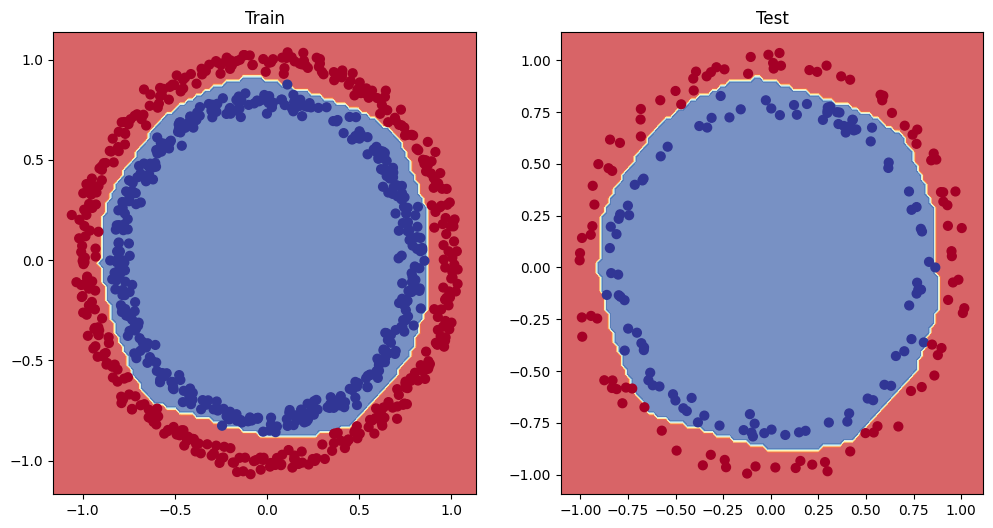

In [221]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [222]:
## Changed the amount of neurons from 10 -> 20 and made the data more acccurate

## 7. Replicating non-linear activation functions
Neural networks, rather than telling the model what to learn, we provide the tools to discover the patterns in data and it tried to figure out the best patterns on its own
<br> And these tools are linear and non-linear functions

In [223]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

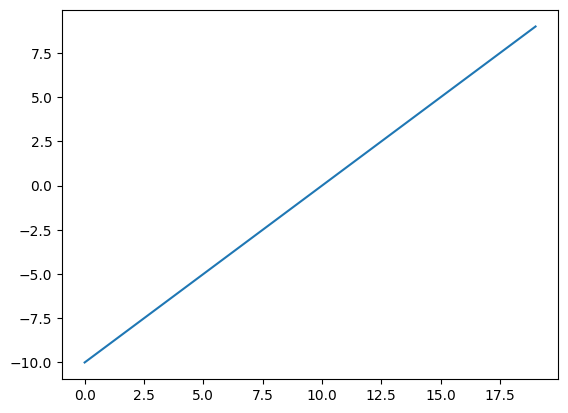

In [224]:
# Visualize the tensor
plt.plot(A)

In [225]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

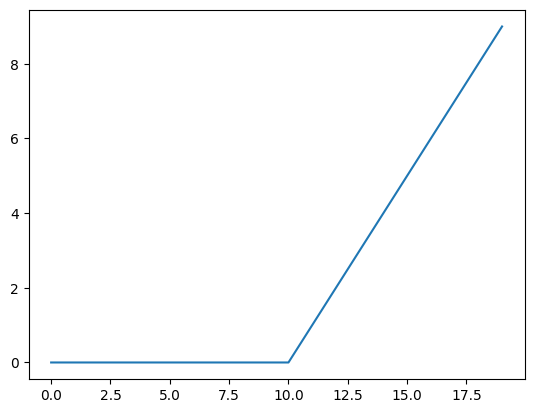

In [226]:
plt.plot(relu(A))

In [227]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [228]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

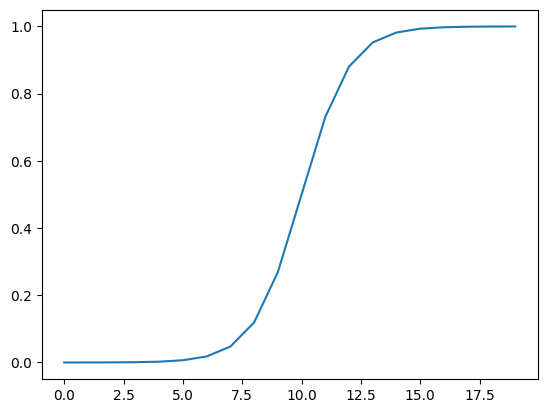

In [229]:
plt.plot(sigmoid(A))

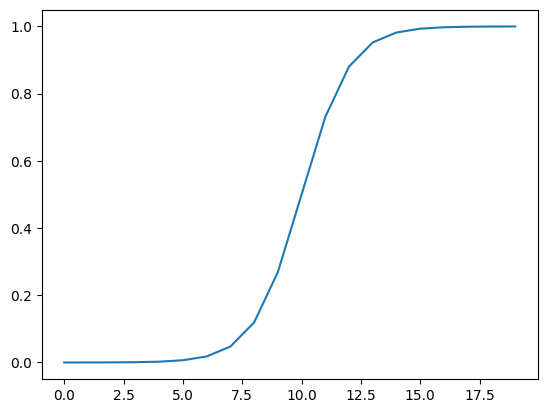

In [230]:
plt.plot(torch.sigmoid(A))

## 8. Putting it all together with a Multiclass Classification problem
* Binary classification = one thing or another (cat vs. dog, spam vs. not spam)
* Multiclass classification = more than one thing or another (cat vs. dog vs. chicken)

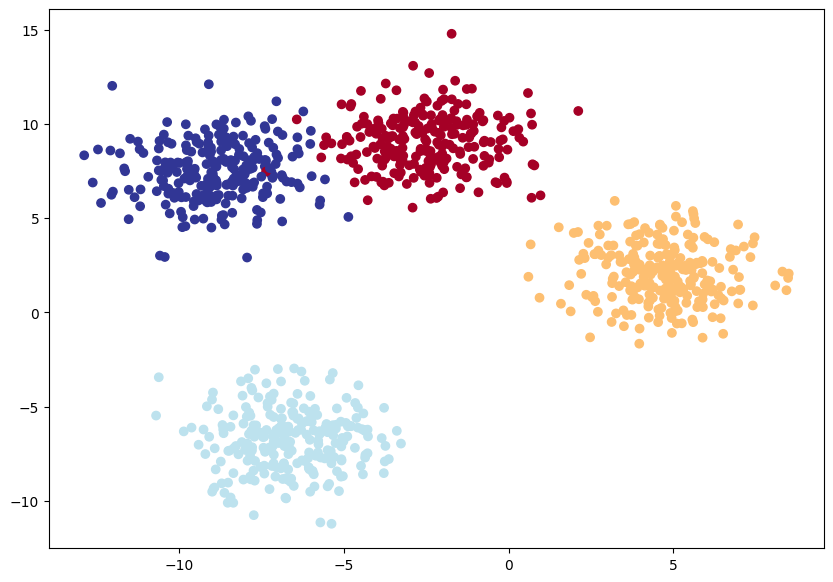

In [231]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyper parameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn our data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

# 4. Plot Data (visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu
            )

### 8.2 Building a multi-class classification model in PyTorch

In [232]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [233]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        # input_layers (int): Number of input features to the model
        # output features (int): Number of output features (number of output classes_
        # hidden_units (int)L Number of hidden units between layers, default 8

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [234]:
X_blob_train.shape

torch.Size([800, 2])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [235]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Optimization function
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1) # learning rate is a hyper parameter you can change


### 4.4 Getting prediction probabilities for a mult-class PyTorch model
To evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels
<br> Logits (raw output of the model) → Pred probs (use 'torch.softmax' → Pred Labels (take the argmax of the prediction probabilities)

In [236]:
# Let's get some raw outputs of our model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_logits


tensor([[-7.6459e-01, -7.4120e-01, -1.5777e+00, -1.1376e+00],
        [-9.7256e-02, -9.4310e-01, -5.9631e-01, -1.3715e-01],
        [ 2.5277e-01, -2.3794e-01,  1.8817e-01, -6.5686e-03],
        [-4.1340e-01, -5.2042e-01, -9.3033e-01, -6.9626e-01],
        [-3.1184e-01, -1.3736e+00, -1.1991e+00, -3.8337e-01],
        [-1.4971e-01, -1.0617e+00, -7.1069e-01, -1.6452e-01],
        [ 1.5388e-01, -2.8874e-01,  1.5199e-01, -1.0874e-02],
        [-2.1543e-01, -1.1795e+00, -9.3000e-01, -2.7448e-01],
        [ 2.4432e-01, -2.4716e-01,  1.6492e-01,  6.1044e-03],
        [-2.3286e-01, -1.2120e+00, -9.8487e-01, -3.0037e-01],
        [-1.7742e-01, -1.1008e+00, -8.2929e-01, -2.3689e-01],
        [-9.4082e-01, -7.8985e-01, -1.8480e+00, -1.3347e+00],
        [-2.9723e-01, -1.3458e+00, -1.1543e+00, -3.6287e-01],
        [-2.9006e-01, -1.3393e+00, -1.1146e+00, -3.3518e-01],
        [-3.3713e-01, -1.4374e+00, -1.2379e+00, -3.8029e-01],
        [-1.0260e-01, -9.5066e-01, -6.1913e-01, -1.5105e-01],
        

In [237]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [238]:
torch.sum(y_pred_probs[0])


tensor(1.0000)

In [239]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [240]:
# Convert our model's predictions to labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [241]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Create training and testing loop

In [242]:
# Set random seed
torch.manual_seed(42)
EPOCHS = 1000

# Move data to device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.long().to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(EPOCHS):

    ### TRAINING
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Loss + Accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### TESTING
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_accuracy = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")


Epoch: 0 | Loss: 1.1588 | Accuracy: 40.38% | Test Loss: 1.0755 | Test Accuracy: 48.00%
Epoch: 100 | Loss: 0.0331 | Accuracy: 99.25% | Test Loss: 0.0243 | Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.0266 | Accuracy: 99.25% | Test Loss: 0.0165 | Test Accuracy: 99.50%
Epoch: 300 | Loss: 0.0250 | Accuracy: 99.25% | Test Loss: 0.0144 | Test Accuracy: 99.50%
Epoch: 400 | Loss: 0.0243 | Accuracy: 99.25% | Test Loss: 0.0134 | Test Accuracy: 99.50%
Epoch: 500 | Loss: 0.0238 | Accuracy: 99.25% | Test Loss: 0.0127 | Test Accuracy: 99.50%
Epoch: 600 | Loss: 0.0234 | Accuracy: 99.25% | Test Loss: 0.0122 | Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.0231 | Accuracy: 99.25% | Test Loss: 0.0118 | Test Accuracy: 99.50%
Epoch: 800 | Loss: 0.0228 | Accuracy: 99.25% | Test Loss: 0.0115 | Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.0225 | Accuracy: 99.25% | Test Loss: 0.0112 | Test Accuracy: 99.50%


### 8.6 Making and evaluating predictions with PyTorch multi-class model

In [274]:
# Make Predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_train) # logits -> prediction probabilities -> pred labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred[:10], y_blob_train[:10]

(tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0]),
 tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0]))

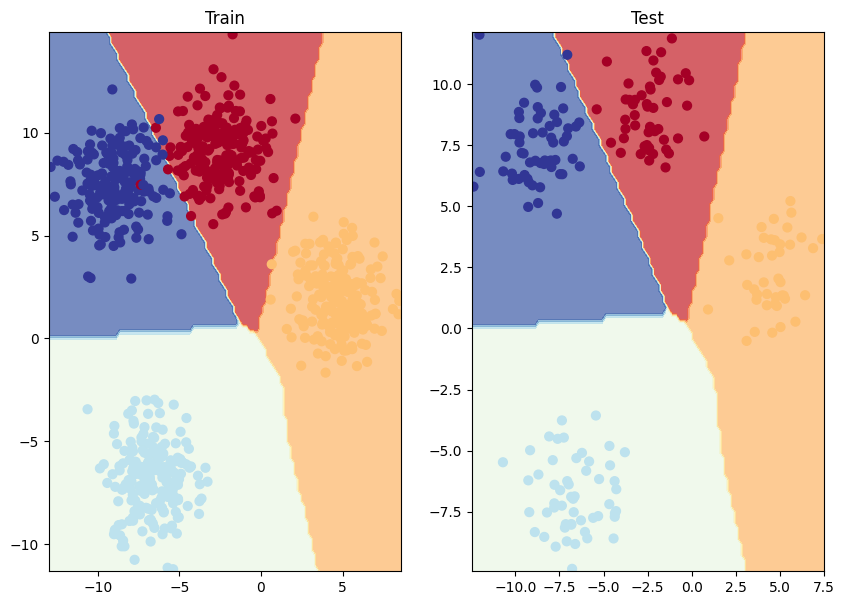

In [275]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)
* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report